## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [66]:
import re
import requests

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)
pd.pandas.set_option('display.max_rows', None)

## Prepare the data set

In [67]:
# load the data - it is available open source and online
data = pd.read_csv('/Users/drewmelendez/Documents/GitHub/deploying-machine-learning-models/titanic_data.csv')

# display data
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1310,1,1,"Name1310, Miss. Surname1310",female,NaN,0,0,SOTON/O2 3101272,76.760165,NaN,C
1,1311,0,3,"Name1311, Col. Surname1311",male,29.0,0,0,223596,10.193097,NaN,S
2,1312,0,3,"Name1312, Mr. Surname1312",male,20.0,0,0,54636,12.029416,C83,C
3,1313,0,3,"Name1313, Mr. Surname1313",male,27.0,0,0,PC 17760,13.429448,NaN,S
4,1314,0,3,"Name1314, Mr. Surname1314",male,32.0,0,0,364512,4.840769,E33,C


In [68]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [69]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['Cabin'] = data['Cabin'].apply(get_first_cabin)

In [70]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['Title'] = data['Name'].apply(get_title)

In [71]:
# cast numerical variables as floats

data['Fare'] = data['Fare'].astype('float')
data['Age'] = data['Age'].astype('float')

In [72]:
# drop unnecessary variables

data.drop(labels=['Name','Ticket','PassengerId'], axis=1, inplace=True)

# display data
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
0,1,1,female,NaN,0,0,76.760165,NaN,C,Miss
1,0,3,male,29.0,0,0,10.193097,NaN,S,Other
2,0,3,male,20.0,0,0,12.029416,C83,C,Mr
3,0,3,male,27.0,0,0,13.429448,NaN,S,Mr
4,0,3,male,32.0,0,0,4.840769,E33,C,Mr


In [73]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Survived  1000000 non-null  int64  
 1   Pclass    1000000 non-null  int64  
 2   Sex       1000000 non-null  object 
 3   Age       801400 non-null   float64
 4   SibSp     1000000 non-null  int64  
 5   Parch     1000000 non-null  int64  
 6   Fare      1000000 non-null  float64
 7   Cabin     229805 non-null   object 
 8   Embarked  997760 non-null   object 
 9   Title     1000000 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 76.3+ MB


In [74]:
data = data.dropna(subset=['Cabin'])

In [75]:
# save the data set

data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [76]:
target = 'survived'

In [77]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
2,0,3,male,20.0,0,0,12.029416,C83,C,Mr
4,0,3,male,32.0,0,0,4.840769,E33,C,Mr
13,1,1,male,52.0,0,0,36.843352,E25,S,Mr
20,0,3,male,31.0,0,0,8.909101,B22,S,Mr
22,0,3,male,28.0,0,0,18.390675,B79,S,Mr


In [78]:
vars_num = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

vars_cat = ['Sex', 'Cabin', 'Embarked', 'Title']

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 5
Number of categorical variables: 4


### Find missing values in variables

In [79]:
# first in numerical variables
data[vars_num].isnull().mean()

Pclass    0.000000
Age       0.199517
SibSp     0.000000
Parch     0.000000
Fare      0.000000
dtype: float64

In [80]:
# now in categorical variables
data[vars_cat].isnull().mean()

Sex         0.00000
Cabin       0.00000
Embarked    0.00201
Title       0.00000
dtype: float64

### Determine cardinality of categorical variables

In [81]:
data[vars_cat].nunique()

Sex           2
Cabin       145
Embarked      3
Title         5
dtype: int64

### Determine the distribution of numerical variables

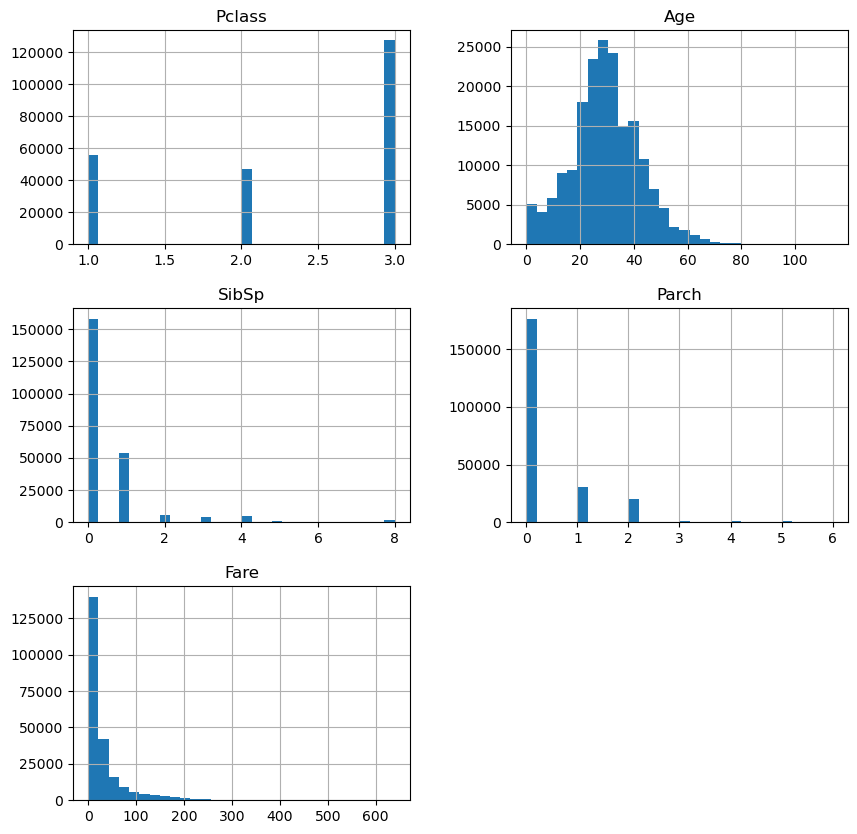

In [82]:
data[vars_num].hist(bins=30, figsize=(10,10))
plt.show()

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [87]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('Survived', axis=1),  # predictors
    data['Survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((183844, 9), (45961, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [88]:
X_train['Cabin'] = X_train['Cabin'].str[0] # captures the first letter
X_test['Cabin'] = X_test['Cabin'].str[0] # captures the first letter

X_train['Cabin'].unique()

array(['D', 'E', 'A', 'C', 'B', 'F', 'G', 'T'], dtype=object)

### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [92]:
for var in ['Age', 'Fare']:

    # add missing indicator
    X_train[var+'_NA'] = np.where(X_train[var].isnull(), 1, 0)
    X_test[var+'_NA'] = np.where(X_test[var].isnull(), 1, 0)

    # replace NaN by median
    median_val = X_train[var].median()

    X_train[var].fillna(median_val, inplace=True)
    X_test[var].fillna(median_val, inplace=True)

X_train[['Age', 'Fare']].isnull().sum()

Age     0
Fare    0
dtype: int64

### Replace Missing data in categorical variables with the string **Missing**

In [93]:
X_train[vars_cat] = X_train[vars_cat].fillna('Missing')
X_test[vars_cat] = X_test[vars_cat].fillna('Missing')

In [94]:
X_train.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Cabin       0
Embarked    0
Title       0
Age_NA      0
Fare_NA     0
dtype: int64

In [95]:
X_test.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Cabin       0
Embarked    0
Title       0
Age_NA      0
Fare_NA     0
dtype: int64

### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [96]:
def find_frequent_labels(df, var, rare_perc):
    
    # function finds the labels that are shared by more than
    # a certain % of the passengers in the dataset
    
    df = df.copy()
    
    tmp = df.groupby(var)[var].count() / len(df)
    
    return tmp[tmp > rare_perc].index


for var in vars_cat:
    
    # find the frequent categories
    frequent_ls = find_frequent_labels(X_train, var, 0.05)
    
    # replace rare categories by the string "Rare"
    X_train[var] = np.where(X_train[var].isin(
        frequent_ls), X_train[var], 'Rare')
    
    X_test[var] = np.where(X_test[var].isin(
        frequent_ls), X_test[var], 'Rare')

In [97]:
X_train[vars_cat].nunique()

Sex         2
Cabin       7
Embarked    4
Title       4
dtype: int64

In [98]:
X_test[vars_cat].nunique()

Sex         2
Cabin       7
Embarked    4
Title       4
dtype: int64

### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [99]:
for var in vars_cat:
    
    # to create the binary variables, we use get_dummies from pandas
    
    X_train = pd.concat([X_train,
                         pd.get_dummies(X_train[var], prefix=var, drop_first=True)
                         ], axis=1)
    
    X_test = pd.concat([X_test,
                        pd.get_dummies(X_test[var], prefix=var, drop_first=True)
                        ], axis=1)
    

X_train.drop(labels=vars_cat, axis=1, inplace=True)
X_test.drop(labels=vars_cat, axis=1, inplace=True)

X_train.shape, X_test.shape

((183844, 20), (45961, 20))

In [100]:
# Note that we have one less column in the test set
# this is because we had 1 less category in embarked.

# we need to add that category manually to the test set

X_train.head()

,Pclass,Age,SibSp,Parch,Fare,Age_NA,Fare_NA,Sex_male,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_Rare,Embarked_Q,Embarked_Rare,Embarked_S,Title_Mr,Title_Mrs,Title_Rare
706937,2,14.0,0,0,16.171124,0,0,True,False,False,True,False,False,False,False,False,True,True,False,False
751140,3,12.0,3,2,44.746703,0,0,True,False,False,False,True,False,False,False,False,True,True,False,False
963341,3,43.0,0,0,7.024639,0,0,True,False,False,False,False,False,False,True,False,False,True,False,False
459152,1,36.0,0,0,39.647962,0,0,True,False,True,False,False,False,False,False,False,False,True,False,False
432859,1,34.0,0,0,121.951910,0,0,True,True,False,False,False,False,False,False,False,False,True,False,False


In [101]:
X_test.head()

,Pclass,Age,SibSp,Parch,Fare,Age_NA,Fare_NA,Sex_male,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_Rare,Embarked_Q,Embarked_Rare,Embarked_S,Title_Mr,Title_Mrs,Title_Rare
433063,3,19.0,0,0,6.966485,0,0,True,True,False,False,False,False,False,False,False,True,True,False,False
387844,1,55.0,0,0,50.742510,0,0,True,False,True,False,False,False,False,False,False,True,True,False,False
239274,2,31.0,0,0,5.690429,0,0,True,False,False,False,True,False,False,False,False,True,True,False,False
629077,2,29.0,0,0,0.000000,0,0,True,False,True,False,False,False,False,False,False,True,True,False,False
834175,3,27.0,0,0,6.020589,0,0,True,False,False,True,False,False,False,True,False,False,True,False,False


In [102]:
# we add 0 as values for all the observations, as Rare
# was not present in the test set

X_test['embarked_Rare'] = 0

In [103]:
# Note that now embarked_Rare will be at the end of the test set
# so in order to pass the variables in the same order, we will
# create a variables variable:

variables = [c  for c in X_train.columns]

variables

['Pclass',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Age_NA',
 'Fare_NA',
 'Sex_male',
 'Cabin_B',
 'Cabin_C',
 'Cabin_D',
 'Cabin_E',
 'Cabin_F',
 'Cabin_Rare',
 'Embarked_Q',
 'Embarked_Rare',
 'Embarked_S',
 'Title_Mr',
 'Title_Mrs',
 'Title_Rare']

### Scale the variables

- Use the standard scaler from Scikit-learn

In [104]:
# create scaler
scaler = StandardScaler()

#  fit  the scaler to the train set
scaler.fit(X_train[variables]) 

# transform the train and test set
X_train = scaler.transform(X_train[variables])

X_test = scaler.transform(X_test[variables])

## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [105]:
# set up the model
# remember to set the random_state / seed

model = LogisticRegression(C=0.0005, random_state=0)

# train the model
model.fit(X_train, y_train)

LogisticRegression(C=0.0005, random_state=0)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [106]:
# make predictions for test set
class_ = model.predict(X_train)
pred = model.predict_proba(X_train)[:,1]

# determine mse and rmse
print('train roc-auc: {}'.format(roc_auc_score(y_train, pred)))
print('train accuracy: {}'.format(accuracy_score(y_train, class_)))
print()

# make predictions for test set
class_ = model.predict(X_test)
pred = model.predict_proba(X_test)[:,1]

# determine mse and rmse
print('test roc-auc: {}'.format(roc_auc_score(y_test, pred)))
print('test accuracy: {}'.format(accuracy_score(y_test, class_)))
print()

train roc-auc: 0.8590598869184389
train accuracy: 0.8043885032962729

test roc-auc: 0.8577738077653603
test accuracy: 0.8049868366658689



That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**